In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-reviews/winemag-data_first150k.csv
/kaggle/input/wine-reviews/winemag-data-130k-v2.json
/kaggle/input/wine-reviews/winemag-data-130k-v2.csv


In [2]:
#Reading our raw data
filepath = '/kaggle/input/wine-reviews/winemag-data-130k-v2.csv'
df_raw = pd.read_csv(filepath)

In [3]:
df_raw.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Let's start with some simple data exploration

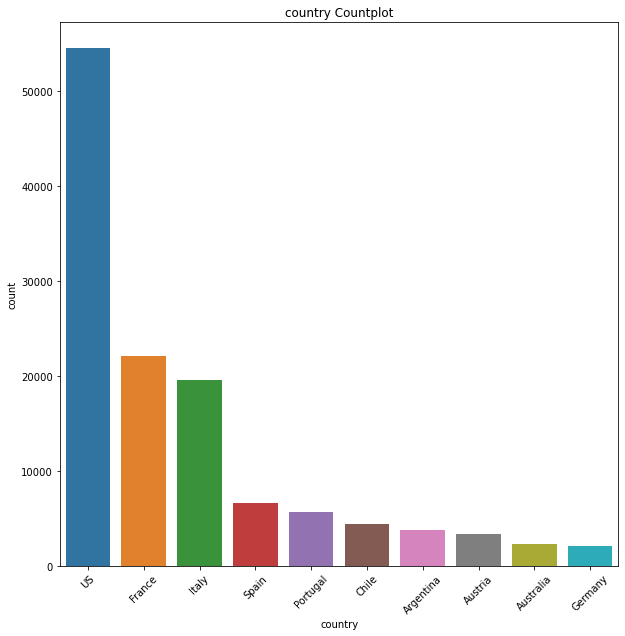

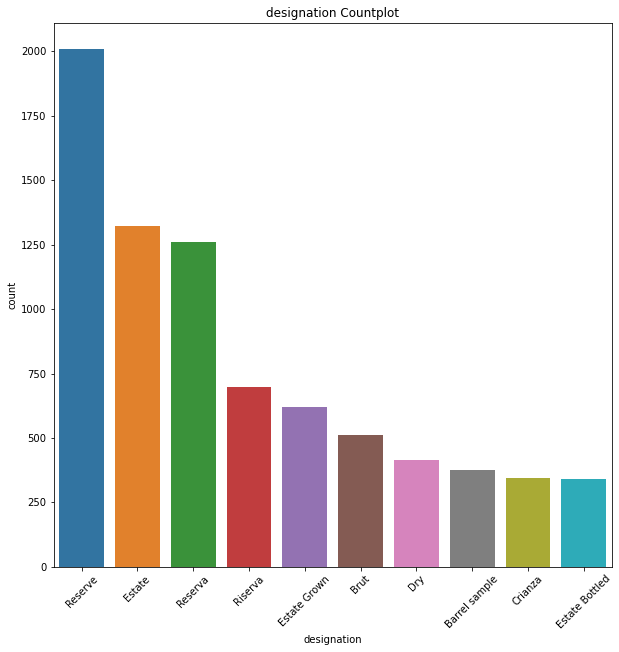

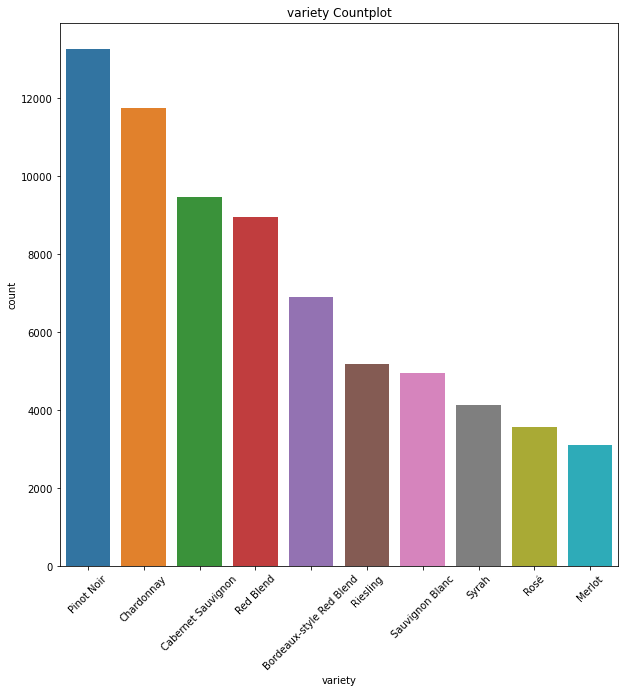

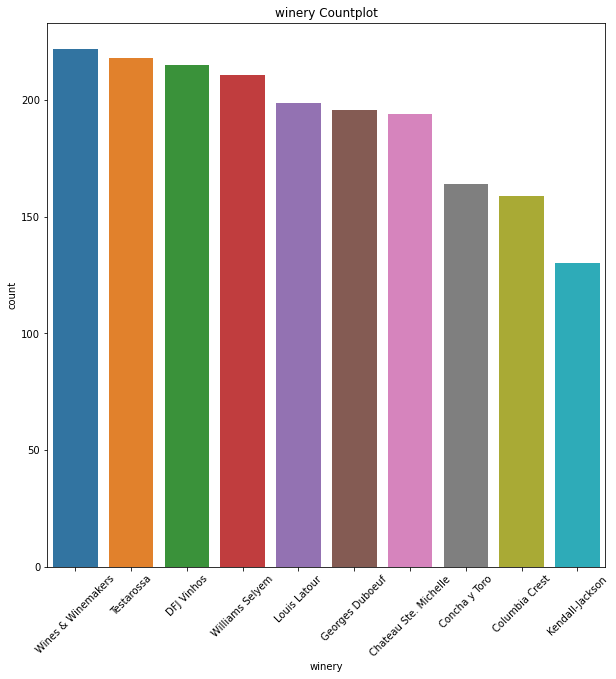

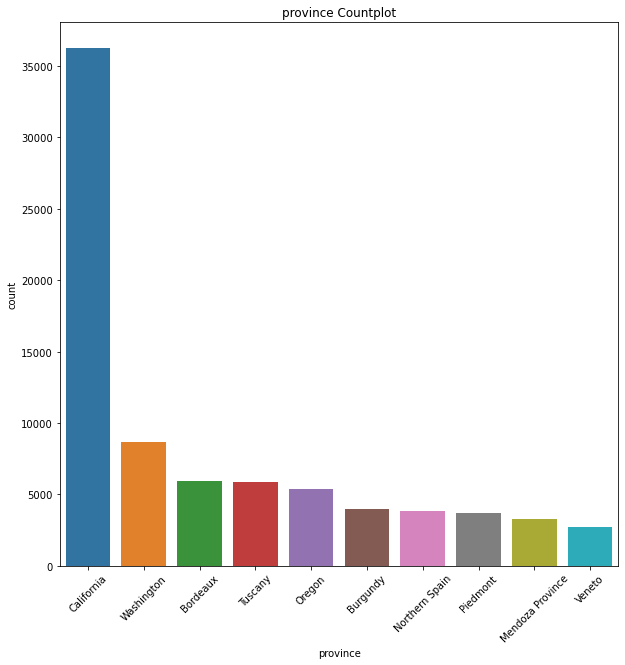

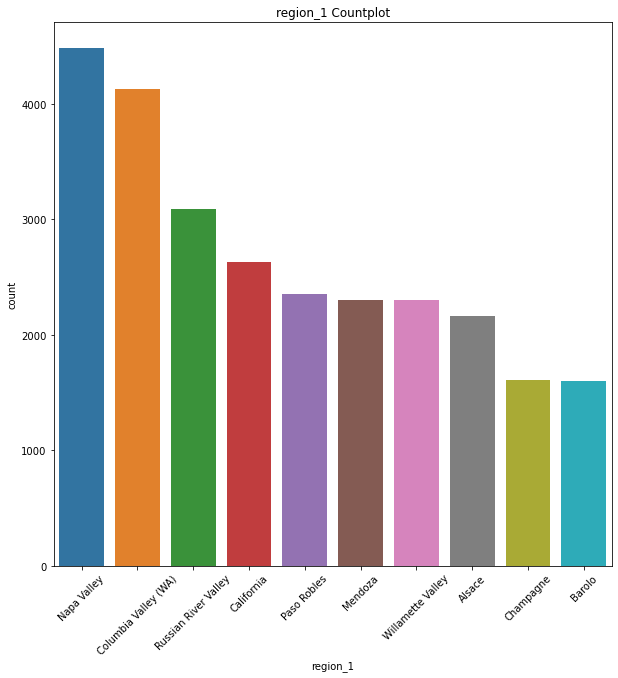

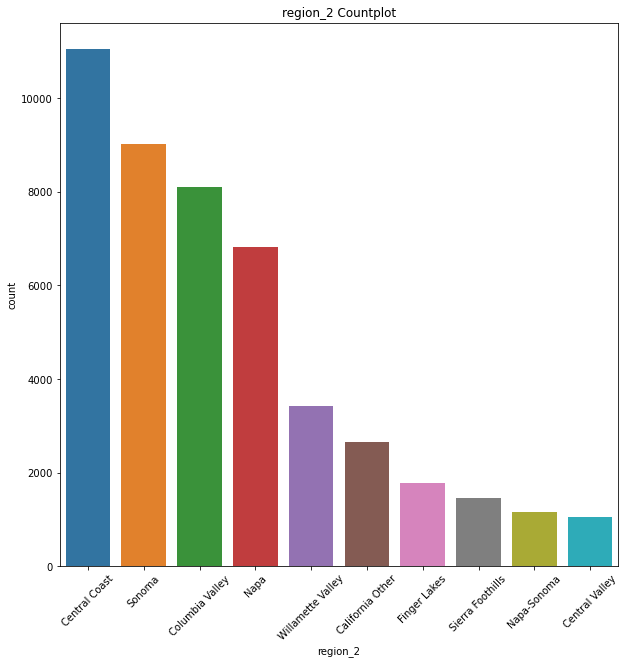

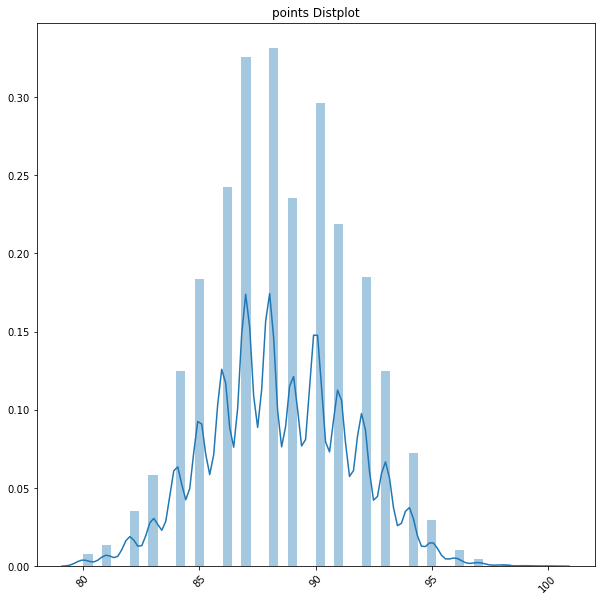

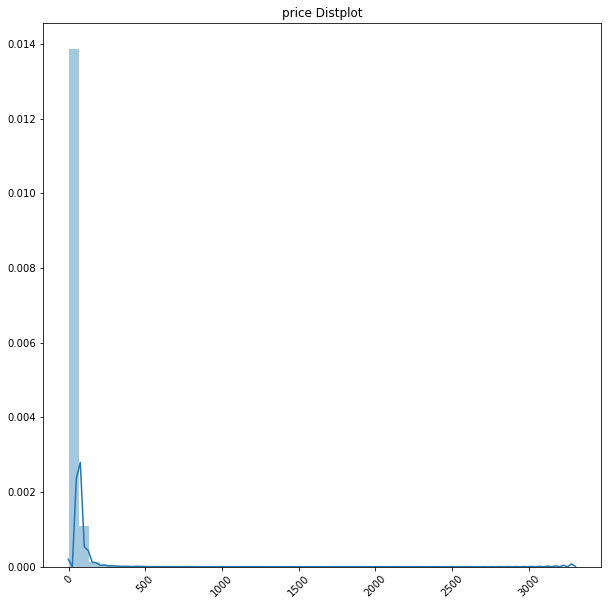

In [4]:
#Visualizing the different columns in our dataframe (we will limit the countplots to the top 10)
columns_of_interest = ['country', 'designation', 'variety', 'winery', 'province', 'region_1', 'region_2']

for column in columns_of_interest:
    
    plt.figure(figsize = (10, 10))
    sns.countplot(x = column, data = df_raw, order = df_raw[column].value_counts().iloc[:10].index)
    plt.xticks(rotation = 45)
    plt.title(column + ' Countplot')
    plt.show()


for column in ['points', 'price']:
    plt.figure(figsize = (10, 10))
    sns.distplot(df_raw[[column]])
    plt.xticks(rotation = 45)
    plt.title(column + ' Distplot')
    plt.show()


In [5]:
#Finding the amount of missing data we have
df_raw.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

### Let's perform some data pre-processing. We will do the following:
- remove some unecessary columns
- remove rows with missing data
- normalize our numerical data by setting the mean to be = 0, and dividing by the standard deviation

In [6]:
#We can remove the following columns to simplify our analysis: designation, description, title, taster_name, twitter_handle, winery, province, region_1, region_2
df_processed = df_raw.drop(columns = ['designation', 'title', 'taster_name', 'taster_twitter_handle', 'Unnamed: 0', 'region_1', 'region_2', 'description', 'province', 'winery'])

#Let's remove any columns with missing data
df_processed = df_processed.dropna()

#Instead of examining all of the worlds wines, let's look at just the 8 most common types of wine
df_processed = df_processed.loc[df_processed['variety'].isin(['Riesling', 'Pinot Gris', 'Sauvignon Blanc', 'Chardonnay',
                                                              'Pinot Noir', 'Zinfandel', 'Syrah', 'Cabernet Sauvignon'])]

#Let's scale our numerical data, since machine learning algorithms tend to work better with scaled data (due to the nature of the underlying math).
df_processed[['points', 'price']] = StandardScaler().fit_transform(df_processed[['points', 'price']])

df_processed.head()

,country,points,price,variety
2,US,-0.542355,-0.608991,Pinot Gris
3,US,-0.542355,-0.633903,Riesling
4,US,-0.542355,0.661504,Pinot Noir
9,France,-0.542355,-0.285139,Pinot Gris
10,US,-0.542355,-0.484432,Cabernet Sauvignon


### Now, let's perform some unsupervised machine learning to see what sort of insights we can gather. Let's try clustering our data. Since we have both numerical and categorical data, a simple k-means clustering technique won't work. We will have to use an advanced technique which can work with both categorical and numerical data - k-prototypes. 

Note: If we had just categorical data, we would use k-modes, and if we had just numerical data, we would use k-means. Since we have both, we use k-prototypes. The only difference between these techniques is the metric that's used to determine the "difference" between two records, and how that "difference" is used to calculate the new cluster center. In k-means, we take the mean of the features of a cluster to determine the center, for k-modes we take the mode of the features (since they are categorical).

In [7]:
#Importing our package that will perform the clustering
from kmodes.kprototypes import KPrototypes

#Converting my dataframe into an array, as that is the input that the KPrototypes package requires
df_processed_array = df_processed.values

#We have to indicate in our array which datapoints are numerical
df_processed_array[:, 0] = df_processed_array[:, 1].astype(float)
df_processed_array[:, 1] = df_processed_array[:, 2].astype(float)

#Now let's run our clustering algorithm (we also have to note here which columns are our categorical ones)
#It is important to choose an optimal number of clusters while clustering, but there is no hard and fast rule - if you use too few clusters, you might not segment your
#population well, and if you use too many, you might oversegment. We will begin by assuming we have 3 distinct clusters. If we were performing k-means clustering,
#we might prefer to use the Elbow Technique.
kproto = KPrototypes(n_clusters = 3, verbose = 2, max_iter = 10)
clusters = kproto.fit_predict(df_processed_array, categorical = [0, 3])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 11974, ncost: 93441.1569536259
Run: 1, iteration: 2/10, moves: 3657, ncost: 88200.71310375098
Run: 1, iteration: 3/10, moves: 3484, ncost: 83338.55001173697
Run: 1, iteration: 4/10, moves: 2380, ncost: 80713.1101064788
Run: 1, iteration: 5/10, moves: 2183, ncost: 78515.55921721549
Run: 1, iteration: 6/10, moves: 1687, ncost: 77248.86264158
Run: 1, iteration: 7/10, moves: 533, ncost: 76991.66440455477
Run: 1, iteration: 8/10, moves: 265, ncost: 76763.91368352712
Run: 1, iteration: 9/10, moves: 73, ncost: 76696.33385804006
Run: 1, iteration: 10/10, moves: 984, ncost: 76427.5256214084
Run: 1, iteration: 11/10, moves: 1069, ncost: 76390.61197257151
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 16625, nc

In [8]:
#Let's see what our centroids look like
print(kproto.cluster_centroids_)

#Let's add our clustering information to our dataframe
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)
    
df_processed['Cluster'] = cluster_dict

[array([[ 8.20367727,  8.20367727],
       [-0.34222057, -0.34222057],
       [ 0.74681745,  0.74681745]]), array([['1.977332969696675', 'Pinot Noir'],
       ['-0.5423552761300052', 'Chardonnay'],
       ['1.03244987751167', 'Pinot Noir']], dtype='<U32')]


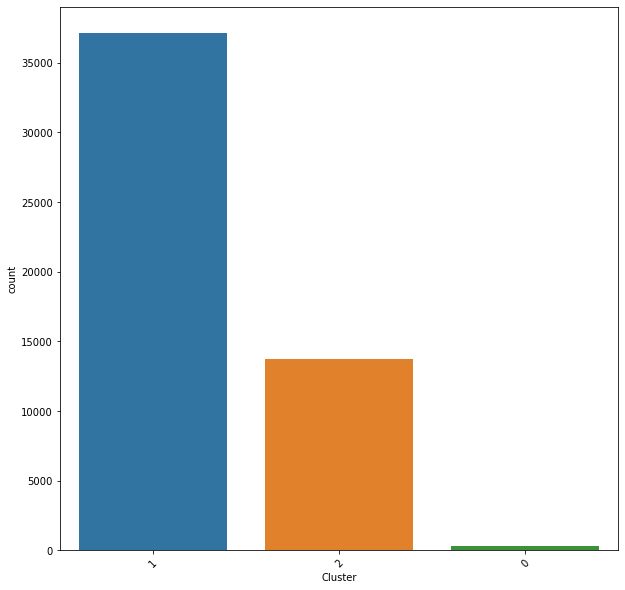

In [9]:
#Let's visualize the number of clusters we have
plt.figure(figsize = (10, 10))
sns.countplot(x = 'Cluster', data = df_processed, order = df_processed['Cluster'].value_counts().index)
plt.xticks(rotation = 45)
plt.show()

In [10]:
df_processed.head()

,country,points,price,variety,Cluster
2,US,-0.542355,-0.608991,Pinot Gris,1
3,US,-0.542355,-0.633903,Riesling,1
4,US,-0.542355,0.661504,Pinot Noir,2
9,France,-0.542355,-0.285139,Pinot Gris,1
10,US,-0.542355,-0.484432,Cabernet Sauvignon,1


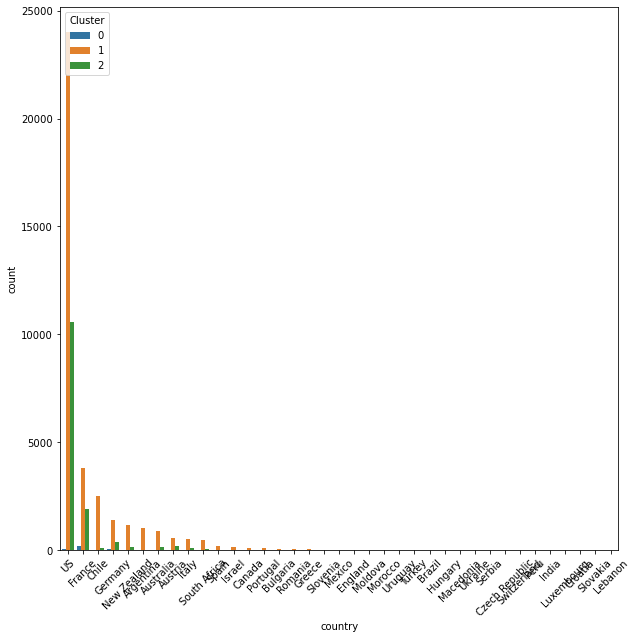

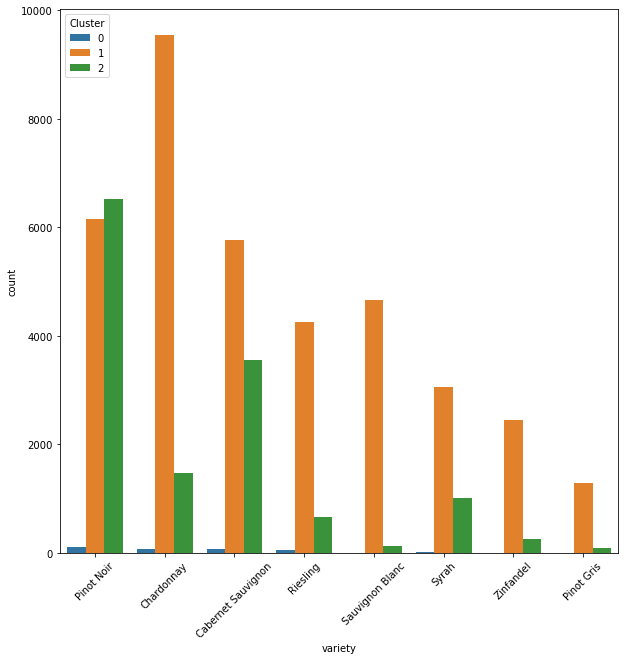

In [11]:
#Let's explore our categorical columns and see if we can find some sort of patterns or trends
plt.figure(figsize = (10, 10))
sns.countplot(x = 'country', data = df_processed, order = df_processed['country'].value_counts().index, hue = 'Cluster')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (10, 10))
sns.countplot(x = 'variety', data = df_processed, order = df_processed['variety'].value_counts().index, hue = 'Cluster')
plt.xticks(rotation = 45)
plt.show()


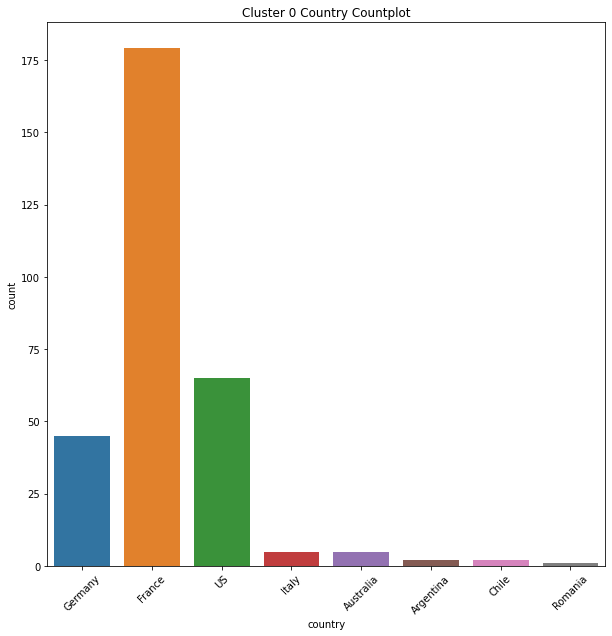

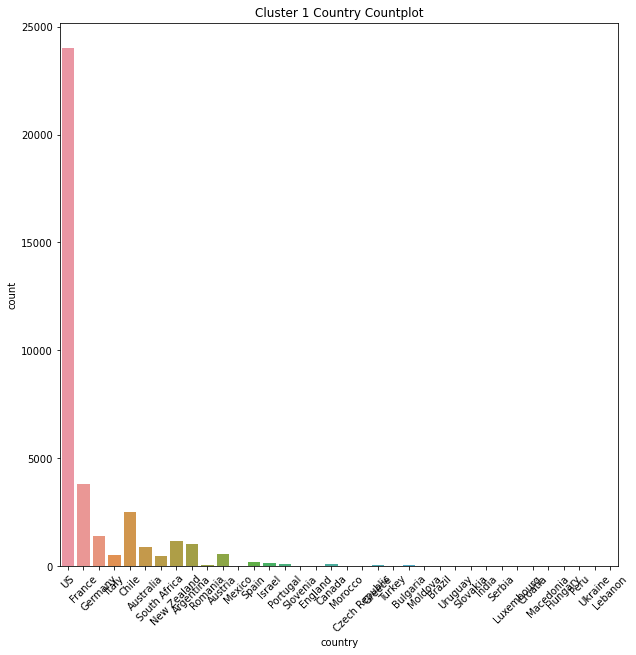

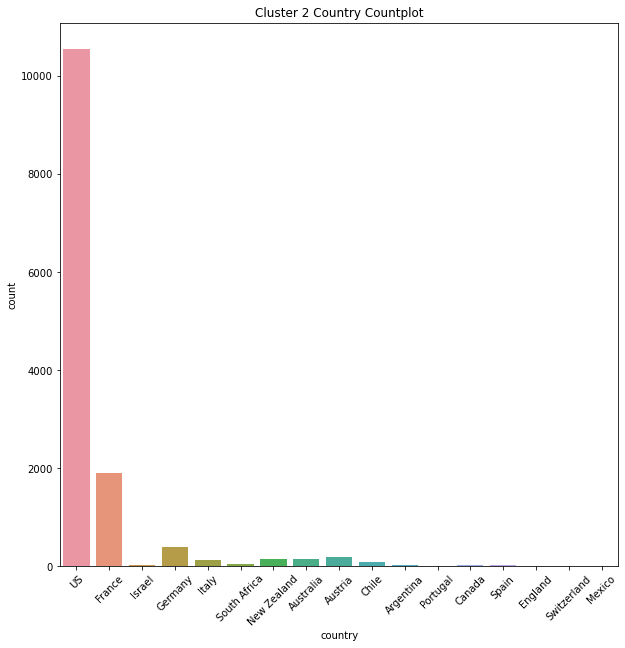

In [12]:
#Now let's look at the Country by Cluster
data = df_processed.loc[df_processed['Cluster'] == 0]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'country', data = data)
plt.xticks(rotation = 45)
plt.title('Cluster 0 Country Countplot')
plt.show()

data = df_processed.loc[df_processed['Cluster'] == 1]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'country', data = data)
plt.xticks(rotation = 45)
plt.title('Cluster 1 Country Countplot')
plt.show()

data = df_processed.loc[df_processed['Cluster'] == 2]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'country', data = data)
plt.xticks(rotation = 45)
plt.title('Cluster 2 Country Countplot')
plt.show()


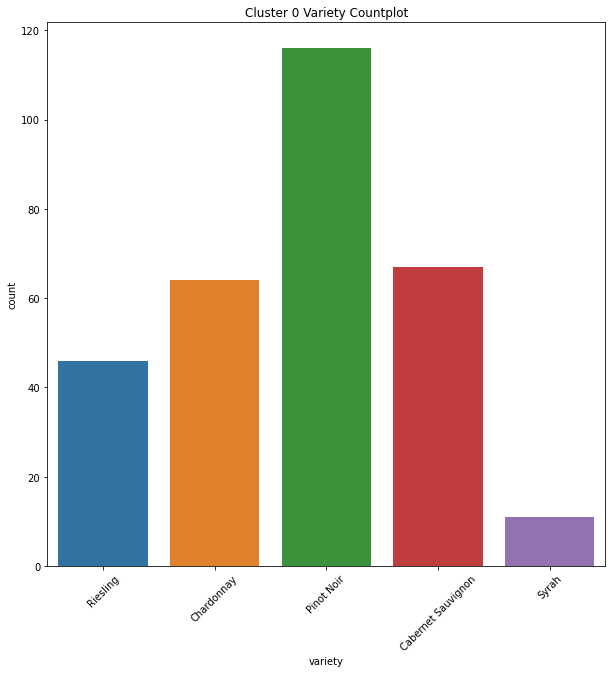

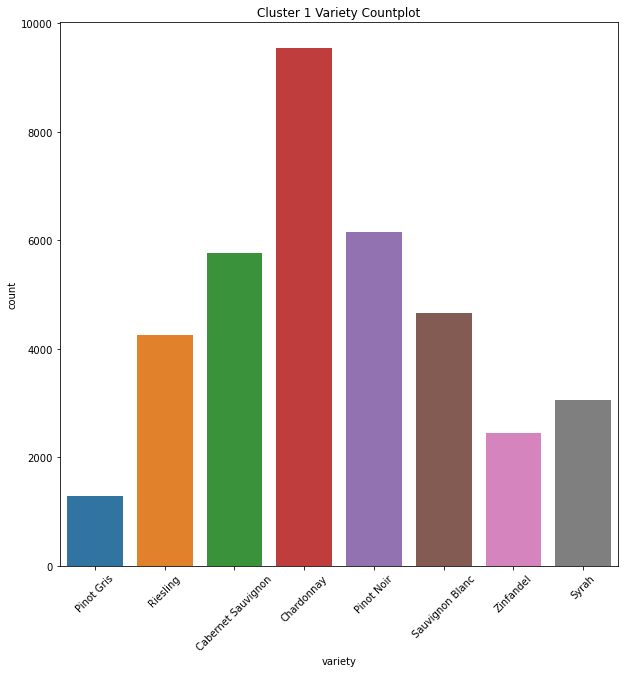

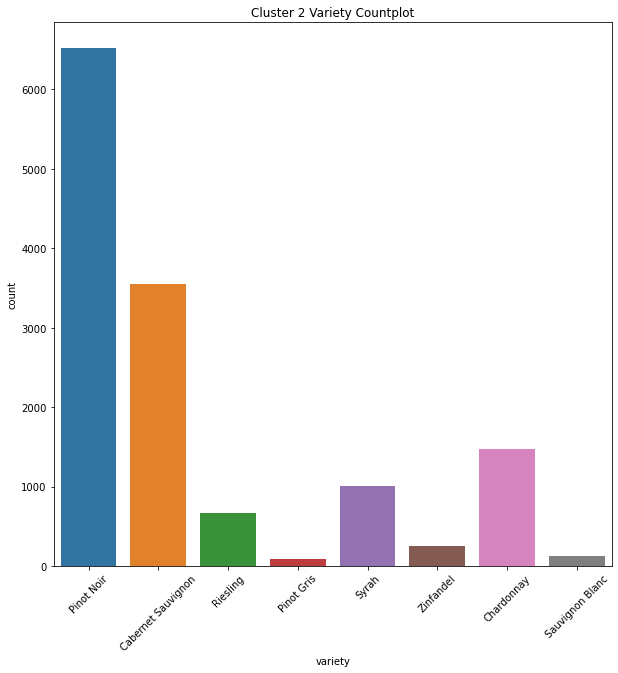

In [13]:
#Let's look at the variety by cluster
data = df_processed.loc[df_processed['Cluster'] == 0]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'variety', data = data)
plt.xticks(rotation = 45)
plt.title('Cluster 0 Variety Countplot')
plt.show()

data = df_processed.loc[df_processed['Cluster'] == 1]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'variety', data = data)
plt.title('Cluster 1 Variety Countplot')
plt.xticks(rotation = 45)
plt.show()

data = df_processed.loc[df_processed['Cluster'] == 2]
plt.figure(figsize = (10, 10))
sns.countplot(x = 'variety', data = data)
plt.title('Cluster 2 Variety Countplot')
plt.xticks(rotation = 45)
plt.show()

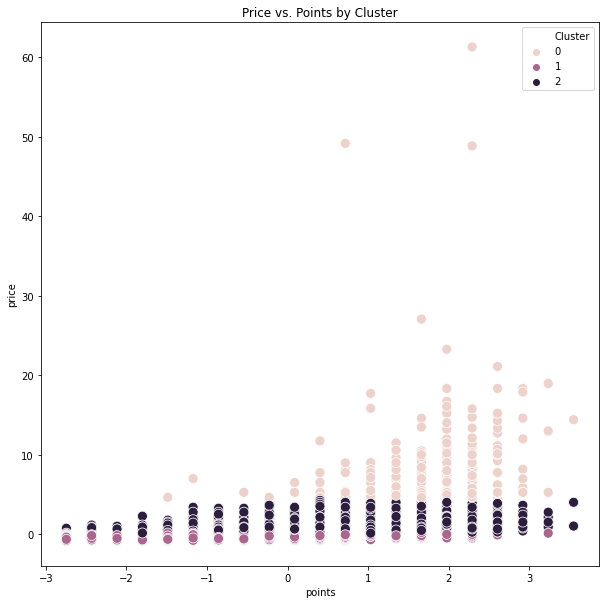

In [14]:
#Let's look at our numerical columns
plt.figure(figsize = (10, 10))
sns.scatterplot(x = 'points', y = 'price', data = df_processed, s = 100, hue = 'Cluster')
plt.title('Price vs. Points by Cluster')
plt.show()

In [15]:
#Investigating the Clusters mean values for point and price, verifying that they are indeed different
for cluster in df_processed.Cluster.unique():
    mean_points = df_processed.loc[df_processed['Cluster'] == cluster]['points'].mean()
    mean_price = df_processed.loc[df_processed['Cluster'] == cluster]['price'].mean()
    
    print('Cluster: ', cluster)
    print('Mean Points: ', mean_points)
    print('Mean_Price: ', mean_price)
    print('---------------------------------')

Cluster:  1
Mean Points:  -0.2986412804337139
Mean_Price:  -0.34222057456463534
---------------------------------
Cluster:  2
Mean Points:  0.7712738983182688
Mean_Price:  0.7468174513221983
---------------------------------
Cluster:  0
Mean Points:  1.7721938773144033
Mean_Price:  8.203677271069083
---------------------------------


# Conclusions

Whew, looks like we got some pretty interesting results!

Throughout this notebook, we did the following:
- Performed an exploratory data analysis
- Cleaned and pre-processed our data
- Clustered our data using K-Prototypes
- Performed a cluster analysis

Looking at our visualizations, we can see that our K-Prototypes algorithm successfully divided our dataset into 2 big (Cluster 0 and 2) and 1 small (Cluster 1) cluster. We can now make the following conclusions about our data: 
 
Cluster 0 and 2 seem to have the same points spread out through their datasets, while Cluster 2 tends to have data with higher points.

Cluster 2 tended to have the wines with the lowest price, followed by Cluster 1, then Cluster 2.

Cluster 0 had wines primarily from the US, Cluster 1 had wines primarily from France, and Cluster 2 had wines primarily from the US.

Cluster 0 and 1 primarily consisted of Pinot Noir, and Cluster 2 primarily consisted of Chardonnay.
